In [1]:
import os
import gzip
import _pickle as pickle

import numpy as np 
import scipy.stats
import arviz

import tensorflow as tf 
from tensorflow import keras
from keras import models, layers, activations, optimizers, regularizers
from keras.utils.vis_utils import plot_model
from keras.models import load_model

import itertools
import matplotlib.pyplot as plt 
import skimage.transform
from sklearn.metrics import confusion_matrix

%run -i ../ImaGene.py 

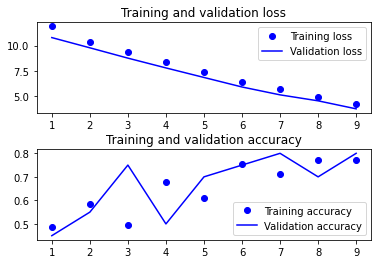

[3.8266873359680176, 0.8199999928474426]


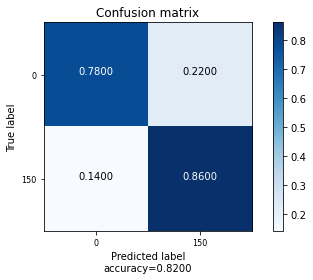

In [4]:
# [0,150]
i = 1
while i <= 10:

    # simluations 
    file_sim = ImaFile(simulations_folder='Data/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=100)
        
    # manipulate data:
    # switch to major/minor allele polarisation
    # filter our monomorphic sites
    # sort rows by genetic distance
    gene_sim.majorminor()
    gene_sim.filter_freq(0.005)
    gene_sim.sort('rows_dist')
    gene_sim.resize((198, 285))
    gene_sim.convert()
    
    # use only classes
    gene_sim.classes = np.array([0,150])
    gene_sim.subset(get_index_classes(gene_sim.targets, gene_sim.classes))
        
    # randomise data
    gene_sim.subset(get_index_random(gene_sim))

    # convert targets to categorical data
    gene_sim.targets = to_binary(gene_sim.targets)
    
    # at first iteration we build the model 
    if i == 1:

        model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])
        model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

        net_LCT = ImaNet(name='[C32+P]+[C64+P]x2+D128')

    # training for iterations from 1 to 9
    if i < 10:
        score = model.fit(gene_sim.data, gene_sim.targets, batch_size=32, epochs=1, verbose=0, validation_split=0.10)
        net_LCT.update_scores(score)
    else:
        # testing for iteration 10
        net_LCT.test = model.evaluate(gene_sim.data, gene_sim.targets, batch_size=None, verbose=0)
        net_LCT.predict(gene_sim, model)

    i += 1
    
net_LCT.plot_train();
print(net_LCT.test);
net_LCT.predict(gene_sim, model)
net_LCT.plot_cm(gene_sim.classes, text=True);

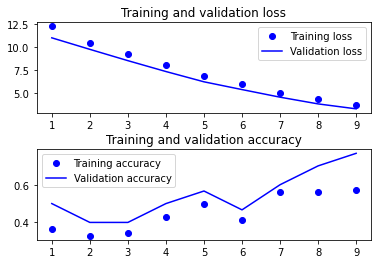

[3.286231756210327, 0.70333331823349]


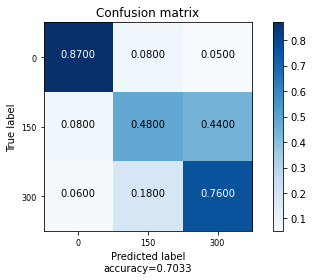

In [5]:
# [0,150,300]
i = 1
while i <= 10:

    # simluations 
    file_sim = ImaFile(simulations_folder='Data/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=100)
        
    # manipulate data:
    # switch to major/minor allele polarisation
    # filter our monomorphic sites
    # sort rows by genetic distance
    gene_sim.majorminor()
    gene_sim.filter_freq(0.005)
    gene_sim.sort('rows_dist')
    gene_sim.resize((198, 285))
    gene_sim.convert()
    
    # use only classes 0,200,400
    gene_sim.classes = np.array([0,150,300])
    gene_sim.subset(get_index_classes(gene_sim.targets, gene_sim.classes))
        
    # randomise data
    gene_sim.subset(get_index_random(gene_sim))

    # convert targets to categorical data
    gene_sim.targets = to_categorical(gene_sim.targets)
    
    # at first iteration we build the model 
    if i == 1:

        model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=len(gene_sim.classes), activation='softmax')])
        model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

        net_LCT = ImaNet(name='[C32+P]+[C64+P]x2+D128')

    # training for iterations from 1 to 9
    if i < 10:
        score = model.fit(gene_sim.data, gene_sim.targets, batch_size=32, epochs=1, verbose=0, validation_split=0.10)
        net_LCT.update_scores(score)
    else:
        # testing for iteration 10
        net_LCT.test = model.evaluate(gene_sim.data, gene_sim.targets, batch_size=None, verbose=0)
        net_LCT.predict(gene_sim, model)

    i += 1
    
net_LCT.plot_train();
print(net_LCT.test);
net_LCT.predict(gene_sim, model)
net_LCT.plot_cm(gene_sim.classes, text=True);